In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# **Загрузка библиотек**

In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import string
import re
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances
from sklearn.decomposition import PCA
from tqdm import tqdm
from functools import lru_cache
import math

In [3]:
data = pd.read_json('/content/gdrive/MyDrive/sber_case/sample.json')

In [4]:
data.head(10)

,id,text
0,1,Ты нашёл их или нет?
1,2,Почему она так со мной поступает?
2,3,Никто туда больше не ходит.
3,4,У него с собой не было тогда денег.
4,5,Почему они с нами так поступают?
5,6,Он всю ночь стонал от сильной боли.
6,7,Я больше не хочу с тобой играть.
7,8,Тому было тогда всего тринадцать лет.
8,9,Что сделал Том с деньгами?
9,10,Том меня сейчас хочет видеть?


# **Класс решения**

In [38]:
class Checker():
    def __init__(self, data):
        '''
        data - pd.DataFrame со столбцами (id, text)
        '''
        # массив словарей {'id': id_text, 'text': text}
        self.id_text = [{'id': data.iloc[i]['id'],
                      'text': "".join(c for c in data.iloc[i]['text'] if (c.isalpha() or c == ' ')).lower()} for i in range(data.shape[0])]

        # словарь {id_text: text}
        self.id_to_text = {data.iloc[i]['id'] : data.iloc[i]['text'] for i in range(data.shape[0])}
        # pd.DataFrame ответа
        self.answer = data
        # сторонние тексты
        self.other_text = None
        self.vector_words = None

    def levenshtein_distance(self, sent1: str, sent2: str) -> int:
        '''
        Метод для нахождения расстояния Левенштейна, используя три разных способа
        input: два предложения (только буквы)
        return: расстояние Левенштейна в процентах
        '''
        big = max(len(sent1), len(sent2))
        return (big - min(self.levenshtein_distance_back(' '.join(sorted(sent1.split())), ' '.join(sorted(sent2.split()))),
                   self.levenshtein_distance_back(sent1, sent2),
                   self.update_levenshtein_distance_back(' '.join(sorted(sent1.split())), ' '.join(sorted(sent2.split()))))) / big * 100

    @lru_cache(4000)
    def update_levenshtein_distance_back(self, sent1: str, sent2: str) -> int:
        '''
        Метод для нахождения расстояния Левенштейна, который ищет каждому слову из первого
        предложения максимально похожее слово из второго предложения

        input: два предложения (только буквы)
        return: количество различных символов
        '''
        sent1, sent2 = sorted([sent1, sent2], key=lambda x: len(x.split()), reverse=True)
        same = dict()
        all_delta = 0
        used_word2 = [0 for i in range(len(sent2.split()))]
        for word1 in sent1.split():
            delta = np.inf
            same_word = ''
            n = -1
            for i, word2 in enumerate(sent2.split()):
                now = self.levenshtein_distance_back(word1, word2)
                if now < delta and not used_word2[i]:
                    delta = now
                    same_word = word2
                    n = i
            if n != -1:
                used_word2[n] = 1
            same[word1] = same_word
            if delta != np.inf:
                all_delta += delta
            else:
                all_delta += len(word1)
        return all_delta

    @lru_cache(4000)
    def levenshtein_distance_back(self, sent1, sent2):
        '''
        Метод для нахождения расстояния Левенштейна

        input: два предложения (только буквы)
        return: количество различных символов
        '''
        len1, len2 = len(sent1), len(sent2)
        dp = [[0 for _ in range(len2 + 1)] for _ in range(len1 + 1)]
        for i in range(len1 + 1):
            for j in range(len2 + 1):
                if i == 0:
                    dp[i][j] = j
                elif j == 0:
                    dp[i][j] = i
                elif sent1[i - 1] == sent2[j - 1]:
                    dp[i][j] = dp[i - 1][j - 1]
                else:
                    dp[i][j] = 1 + min(dp[i][j - 1], dp[i - 1][j], dp[i - 1][j - 1])

        return dp[len1][len2]

    def levenshtein_checker(self, threshold=80) -> None:
        '''
        Метод для поиска в data близких предложений по рассстоянию Левенштейна
        threshold - минимальный порог различия в процентах
        '''
        same_dict = dict()
        text_1, text_2 = self.id_text.copy(), self.id_text.copy()

        for i in tqdm(range(len(text_1)), desc='levenshtein_checker'):
            same_dict[text_1[i]['id']] = []
            for j in range(len(text_2)):
                value = self.levenshtein_distance(text_1[i]['text'], text_2[j]['text'])
                if value >= threshold and text_1[i]['id'] != text_2[j]['id']:
                    if same_dict.get(text_1[i]['id']):
                        same_dict[text_1[i]['id']].append((text_2[j]['id'], value))
                    else:
                        same_dict[text_1[i]['id']] = [(text_2[j]['id'], value)]

        for key, value in same_dict.items():
            same_dict[key] = sorted(value, key=lambda x : x[1], reverse=True)

        same_advanced_dict = dict()
        for key, value in same_dict.items():
            same_advanced_dict[key] = [(self.id_to_text[pair[0]], pair[1]) for pair in value]
        if 'same_texts_levenshtein' in self.answer:
            self.answer.drop('same_texts_levenshtein', axis=1, inplace=True)

        same_advanced_data = pd.DataFrame({'id': list(same_advanced_dict.keys()),
                                  'same_texts_levenshtein': list(same_advanced_dict.values())})
        self.answer = self.answer.merge(same_advanced_data, how='left', on='id')

    def load_other_text(self, paths: list) -> None:
        '''
        Метод для загрузки текстов
        input: список путей до файлов
        '''
        text = []
        for path in paths:
            with open(path) as f:
                text += f.readlines()[:100000]

        self.other_text = ' '.join(text)
        self.other_text = re.split(r'[.|!|?|…]', self.other_text)
        self.other_text = ["".join(c for c in sent if (c.isalpha() or c == ' ')).lower() for sent in self.other_text]
        self.other_text = [sent.strip() for sent in self.other_text]
        self.vector_words = self.to_vector()

    def make_n_gram(self, sent, n_grams=2):
        grams = []
        sent = sent.replace(' ', '#')
        grams = [sent[i:i + n_grams] for i in range(len(sent) - n_grams + 1)]
        return grams

    def to_vector(self, n_grams=-1):
        count_grams_other = Counter(' '.join(self.other_text).split()) if n_grams == -1 \
                            else Counter([item for sent in self.other_text for item in self.make_n_gram(sent, n_grams)])
        V_DIM_other = sum([v >= 10 for v in count_grams_other.values()]) if n_grams == -1 \
                            else sum([v >= 50 for v in count_grams_other.values()])
        count_grams = Counter(' '.join(sent['text'] for sent in self.id_text).split()) if n_grams == -1 \
                            else Counter([item for sent in self.id_text for item in self.make_n_gram(sent['text'], n_grams)])
        V_DIM_sample = sum([v >= 1 for v in count_grams.values()])

        wordID = dict()
        count_word = count_grams_other.most_common(V_DIM_other) + count_grams.most_common(V_DIM_sample)
        words = set([pair[0] for pair in count_word])
        V_DIM = len(words)
        for i, word in enumerate(words):
            wordID[word] = {"id": i}

        def word_to_id(word):
            if word in wordID:
                return wordID[word]['id']

        p12 = np.zeros((V_DIM, V_DIM))
        p1 = np.zeros((V_DIM,))


        desc = f'to_vector_n_grams_{n_grams}' if n_grams != -1 else 'to_vector_words'
        for sent in tqdm(self.other_text + [sent['text'] for sent in self.id_text], desc=desc):
            words = set(sent.split()) if n_grams == -1 else self.make_n_gram(sent, n_grams)
            for w1 in words:
                p1[word_to_id(w1)] += 1
                for w2 in words:
                    if w2 in wordID:
                        p12[word_to_id(w1), word_to_id(w2)] += 1

        p12 /= p12.sum()
        p1 /= p1.sum()
        vecs = p12 / (p1.reshape((V_DIM,1)) @ p1.reshape((1, V_DIM)))
        vecs[vecs <= 0] = 1
        vecs = np.log(vecs)
        vecs[vecs <= 0] = 0

        pca = PCA()
        res = pca.fit_transform(vecs)
        E_DIM = 2000
        res = res[:, :E_DIM]
        res = (res-res.mean(axis=0))/(res.std(axis=0) * np.sqrt(E_DIM))
        vector_grams = pd.DataFrame(res)
        vector_grams.index = [grams for grams in list(wordID.keys())]
        return vector_grams

    def get_distance(self, data, tf_idf=False, n_grams=-1):
        def word_to_vec(word):
            if word in data.index:
                return data.loc[word].values

        if tf_idf:
            vector_sent = self.embedding_with_tf_idf()
            dist_matrix = cosine_distances(vector_sent)
            return dist_matrix

        vector_sent = []
        for sent in self.id_text:
            words = sent['text'].split() if n_grams == -1 else self.make_n_gram(sent['text'], n_grams)
            vector = sum(word_to_vec(word) for word in words) / len(words)
            vector_sent.append(vector)
        dist_matrix = cosine_distances(vector_sent)
        return dist_matrix

    def to_vector_tf_idf(self) -> list:
        '''
        Метод векторизует прдложения, используя td_idf
        return: вектора предложений
        '''
        count_word = Counter(' '.join(sent['text'] for sent in self.id_text).split())
        texts = [item['text'] for item in self.id_text]
        words_counter = list(count_word.keys())
        all_texts = texts + self.other_text
        all_count_word = Counter(' '.join(sent for sent in all_texts).split())
        all_words_counter = list(all_count_word.keys())

        text_vectors = []
        for sent in texts:
            words = sent.split()
            word_counts_in_sent = Counter(words)
            vec = []
            for j in words:
                ind = words_counter.index(j)
                count = word_counts_in_sent[j]
                vec.append((ind, count))
            text_vectors.append(vec)

        vector_tf_idf = np.zeros((len(text_vectors), len(count_word)))
        row = 0
        for sub_list in text_vectors:
            for a, b in sub_list:
                vector_tf_idf[row][a] = b * (math.log((len(all_texts) + 1)/(1 + sum([1.0 for i in all_texts if all_words_counter[a] in i]))) + 1)
            row+=1
        vector_tf_idf = self.normalize_arrays(vector_tf_idf)
        return vector_tf_idf

    def embedding_with_tf_idf(self) -> list:
        '''
        Метод векторизует прдложения, суммируя векторные прдставления слов, умноженные на веса из матрицы td_idf
        return: вектора предложений
        '''
        vector_tf_idf = self.to_vector_tf_idf()
        count_word = Counter(' '.join(sent['text'] for sent in self.id_text).split())
        words_counter = list(count_word.keys())
        vectors = self.vector_words
        def word_to_vec(word):
            if word in vectors.index:
                return vectors.loc[word].values
            print(word)
        vector_sent = []
        row = 0
        for sent in tqdm(self.id_text, desc='embedding_with_tf_idf'):
            words = sent['text'].split()
            vector = sum(word_to_vec(word) * vector_tf_idf[row][words_counter.index(word)] for word in words)
            vector_sent.append(vector)
            row += 1
        return vector_sent

    # def all_cheker(self, threshold: float=0.5, n_grams: int=2):
    #     dist_emb = self.get_distance(self.to_vector())
    #     dist_gram = self.get_distance(self.to_vector(n_grams), n_grams)
    #     dist_tf_idf = cosine_distances(self.to_vector_tf_idf())
    #     dist_matrix = (np.array(dist_emb) + np.array(dist_gram) + np.array(dist_tf_idf)) / 3
    #     self.find_close_sentense(dist_matrix, threshold, 'same_texts_all')

    def find_close_sentence(self, data, threshold: float, name_colto_answer: str, n_grams: int=-1):
        '''
        Метод выбирает рерайты, которые имеют расстояние до целевого предложения меньше порога - threshold
        '''
        nearest_dict = {}
        for i in tqdm(range(len(self.id_text)), desc='find_close_sentences'):
            distances = list((sent['id'], data[i][j]) for j, sent in enumerate(self.id_text))
            distances.sort(key=lambda x: x[1])
            nearest_dict[self.id_text[i]['id']] = [(id, dist) for id, dist in distances \
                                                if dist <= threshold and self.id_text[i]['id'] != id]
        nearest_advanced_dict = dict()
        for key, value in nearest_dict.items():
            nearest_advanced_dict[key] = [(self.id_to_text[pair[0]], pair[1]) for pair in value]
            if not len(nearest_advanced_dict[key]):
                nearest_advanced_dict[key] = []

        if name_colto_answer in self.answer:
            self.answer.drop(name_colto_answer, axis=1, inplace=True)
        same_advanced_data = pd.DataFrame({'id': list(nearest_advanced_dict.keys()),
                                  name_colto_answer: list(nearest_advanced_dict.values())})
        self.answer = self.answer.merge(same_advanced_data, how='left', on='id')
        self.answer[name_colto_answer] = self.answer[name_colto_answer].map(lambda row: [(sent[0], np.round(sent[1], 3)) for sent in row] if type(row) == list else row)

    def embedding_checker(self, threshold=0.2) -> None:
        '''
        Метод для поиска в data близких предложений по косиносному расстоянию между ними
        с помощью перевода предложений в векторы c весами
        threshold - минимальный порог различия
        '''
        vectors = self.vector_words
        dist_matrix = self.get_distance(vectors, tf_idf=True)
        self.find_close_sentence(dist_matrix, threshold, 'same_texts_embedding')

    def embedding_mean_checker(self, threshold=0.2) -> None:
        '''
        Метод для поиска в data близких предложений по косиносному расстоянию между ними
        с помощью перевода предложений в векторы mean
        threshold - минимальный порог различия
        '''
        vectors = self.vector_words
        dist_matrix = self.get_distance(vectors, tf_idf=False)
        self.find_close_sentence(dist_matrix, threshold, 'same_texts_embedding_mean')

    def embedding_grams_checker(self, n_grams: int=2, threshold: float=0.2) -> None:
        '''
        Метод для поиска в data близких предложений по косиносному расстоянию между ними
        с помощью перевода предложений в векторы на n-граммах
        threshold - максимальный порог различия
        '''
        vectors = self.to_vector(n_grams)
        dist_matrix = self.get_distance(vectors, False, n_grams)
        self.find_close_sentence(dist_matrix, threshold, 'same_texts_embedding_grams', n_grams)

    def tf_idf_checker(self, threshold: float=0.3):
        '''
        Метод для поиска в data близких предложений по косиносному расстоянию между ними
        с помощью перевода предложений в векторы через tf_idf
        threshold - максимальный порог различия
        '''
        vectors = self.to_vector_tf_idf()
        dist_matrix = cosine_distances(vectors)
        self.find_close_sentence(dist_matrix, threshold, 'same_texts_tf_idf')

    def normalize_arrays(self, arrays: list) -> list:
        '''
        Метод нормирует вектор
        return: вектор
        '''
        arrays = np.array(arrays)
        normalized_arrays = arrays / np.linalg.norm(arrays, axis=1, keepdims=True)
        return normalized_arrays

    def unite_columns(self, row: list) -> list:
        '''
        Метод для обработки строк в итоговом DataFrame
        return: список рерайтов для предложения
        '''
        levenshtein = [pair[0] for pair in row['same_texts_levenshtein']] if type(row['same_texts_levenshtein']) == list else row
        embedding = [pair[0] for pair in row['result_all_cos']] if type(row['result_all_cos']) == list else row
        if type(levenshtein) != list and type(embedding) != list:
            return np.nan
        elif type(embedding) != list:
            return levenshtein
        elif type(levenshtein) != list:
            return embedding
        levenshtein = set(levenshtein)
        embedding = set(embedding)
        common = levenshtein & embedding
        only_in_levenshtein = levenshtein - common
        only_in_embedding = embedding - common
        return list(common) + list(only_in_embedding) + list(only_in_levenshtein)

    def all_cheker(self, row, threshold=1.45):
        '''
        Метод для одъединения всех алгоритмов кроме Левенштейна в один
        return: список рерайтов для предложения
        '''
        embedding_tf_idf = row['same_texts_embedding']
        embedding_mean = row['same_texts_embedding_mean']
        tf_idf = row['same_texts_tf_idf']
        n_gramms = row['same_texts_embedding_grams']

        combined_text_weight = embedding_tf_idf + embedding_mean + tf_idf + n_gramms # все голоса алгоритмов
        combined_text = [pair[0] for pair in combined_text_weight]
        unique_elements = list(set(combined_text))
        unique_elements_dict = {i: 0 for i in unique_elements} # кандидаты на рерайт
        for i in combined_text_weight:
            if i[1] < 0.226:
                unique_elements_dict[i[0]] += 500
            else:
                unique_elements_dict[i[0]] += (1 - i[1])
        return [(key, value) for key, value in unique_elements_dict.items() if value > threshold]

    def make_result(self, threshold = 1.3):
        '''
        Метод для одъединения алгоритмов кроме Левенштейна и резйльтата метода all_cheker
        return: список рерайтов для предложения
        '''
        self.answer = self.answer.fillna('[]')
        if 'result_all_cos' in self.answer:
            self.answer.drop('result_all_cos', axis=1, inplace=True)
        self.answer['result_all_cos'] = self.answer.apply(lambda row: self.all_cheker(row, threshold), axis=1)

        if 'result' in self.answer:
            self.answer.drop('result', axis=1, inplace=True)
        self.answer['result'] = self.answer.apply(lambda row: self.unite_columns(row), axis=1)
        return self.answer[['id', 'text', 'result']]

In [39]:
chk = Checker(data)

In [40]:
chk.load_other_text(['/content/gdrive/MyDrive/sber_case/Твен Марк. Приключения Тома Сойера.txt',
                     '/content/gdrive/MyDrive/sber_case/18850745.txt',
                     '/content/gdrive/MyDrive/sber_case/80889690.txt'])

to_vector_words: 100%|██████████| 12959/12959 [00:05<00:00, 2580.23it/s]


In [41]:
chk.embedding_checker(0.3)

find_close_sentences: 100%|██████████| 412/412 [00:00<00:00, 2191.87it/s]


In [42]:
chk.embedding_grams_checker(n_grams=2, threshold=0.25)

find_close_sentences: 100%|██████████| 412/412 [00:00<00:00, 2297.72it/s]


In [43]:
chk.embedding_mean_checker(0.25)

find_close_sentences: 100%|██████████| 412/412 [00:00<00:00, 2314.71it/s]


In [44]:
chk.tf_idf_checker()

find_close_sentences: 100%|██████████| 412/412 [00:00<00:00, 2518.45it/s]


In [45]:
chk.levenshtein_checker(77)

levenshtein_checker: 100%|██████████| 412/412 [04:09<00:00,  1.65it/s]




# **Результат работы**

In [46]:
chk.make_result(1.4)

,id,text,result
0,1,Ты нашёл их или нет?,[]
1,2,Почему она так со мной поступает?,"[Почему она так с ним поступает?, Почему она т..."
2,3,Никто туда больше не ходит.,[Никто больше туда не ходит.]
3,4,У него с собой не было тогда денег.,[У него тогда не было с собой денег.]
4,5,Почему они с нами так поступают?,"[Почему она так с ним поступает?, Почему они т..."
...,...,...,...
407,408,Рому было нечего сказать.,[Тому было нечего сказать.]
408,409,Том ещё нас не видел.,[]
409,410,Мы должны всем им помочь.,[]
410,411,Чего ты свой нос повсюду суёшь?,[]


In [47]:
chk.make_result(1.4).to_excel('finish.xlsx')



# **Построение графиков**

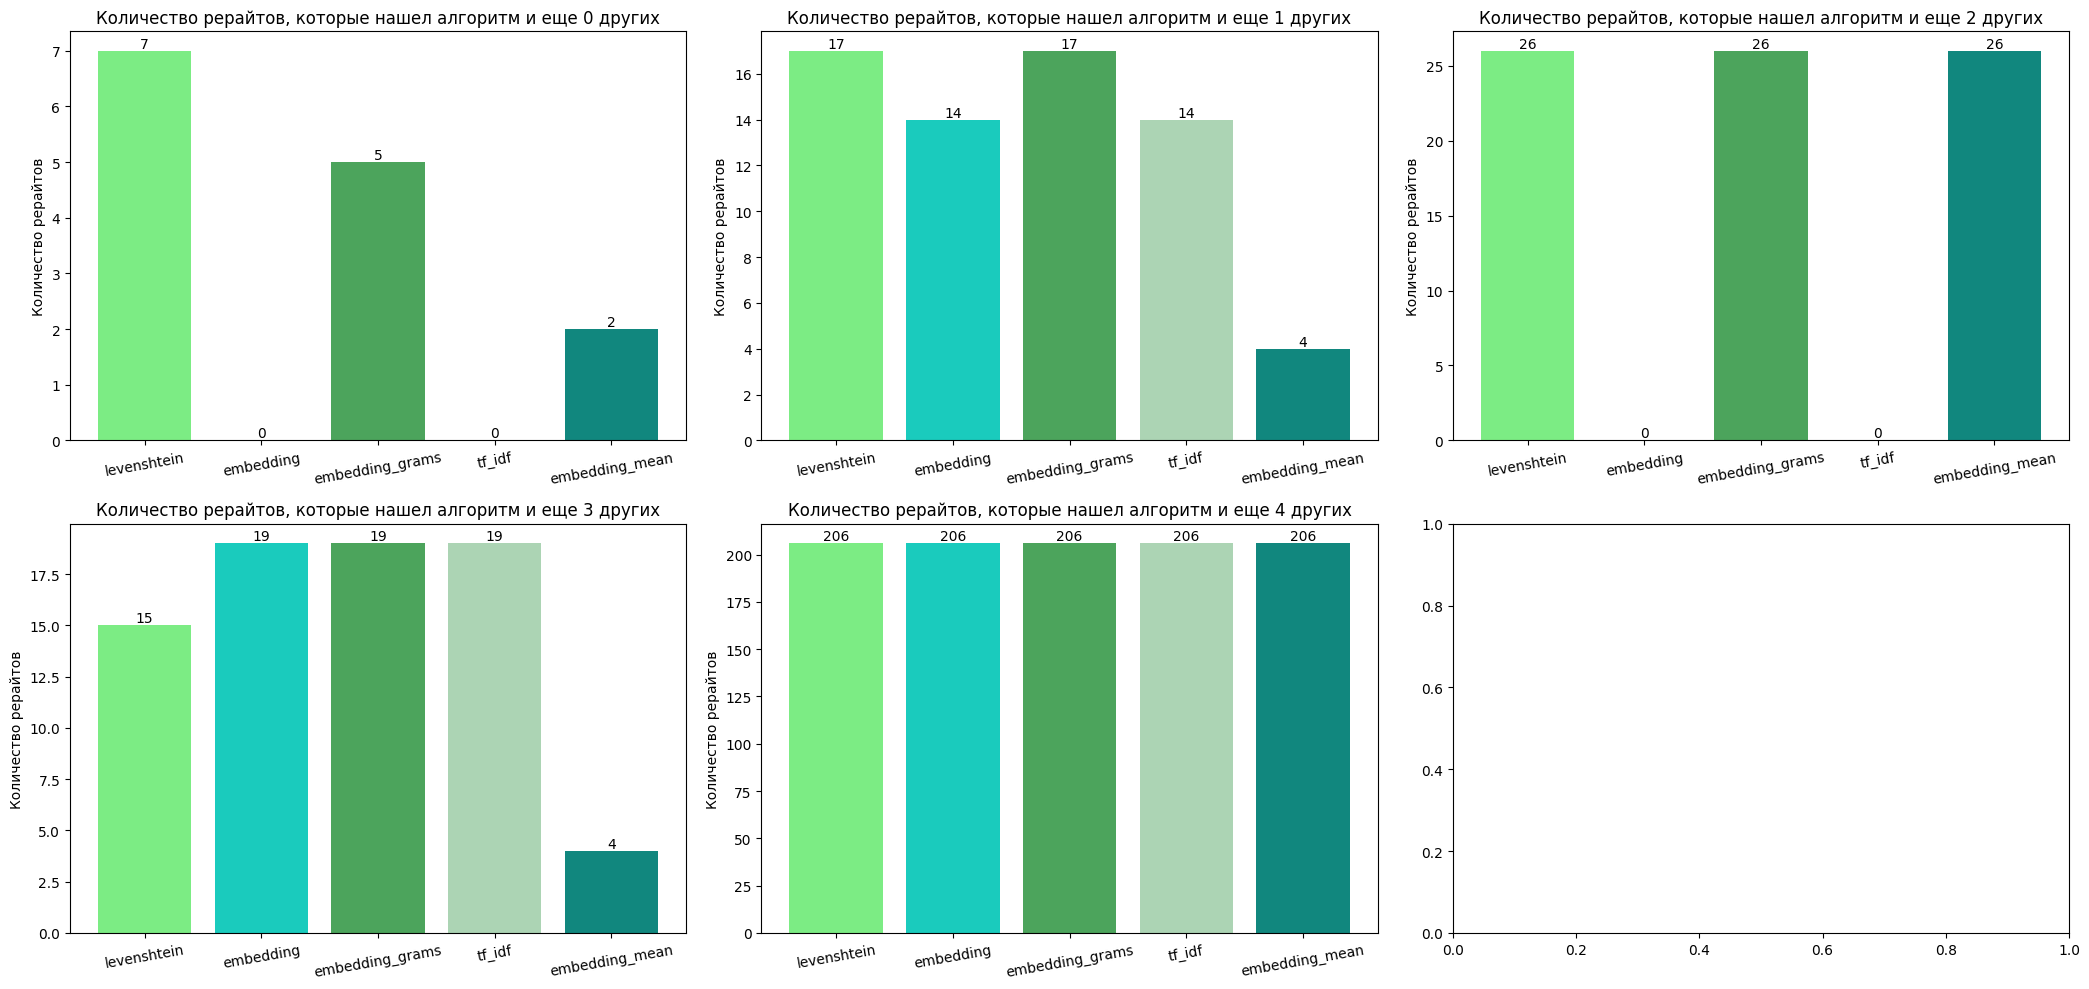

In [49]:
def analysis():
    def check_key_in_dicts(array, key):
        for dictionary in array:
            if key in dictionary:
                return True
        return False
    df = chk.answer
    info_vote = []
    for i in range(len(df)):
        keys = ['same_texts_levenshtein', 'same_texts_embedding', 'same_texts_embedding_grams', 'same_texts_tf_idf', 'same_texts_embedding_mean']
        vote = {}
        for sent in df.iloc[i]['result']:
            if check_key_in_dicts(info_vote, sent):
                continue
            vote[sent] = {key: 0 for key in keys}
            if sent in [part[0] for part in df.iloc[i]['same_texts_levenshtein'] if part]:
                vote[sent]['same_texts_levenshtein'] += 1
            if sent in [part[0] for part in df.iloc[i]['same_texts_embedding'] if part]:
                vote[sent]['same_texts_embedding'] += 1
            if sent in [part[0] for part in df.iloc[i]['same_texts_embedding_grams'] if part]:
                vote[sent]['same_texts_embedding_grams'] += 1
            if sent in [part[0] for part in df.iloc[i]['same_texts_tf_idf'] if part]:
                vote[sent]['same_texts_tf_idf'] += 1
            if sent in [part[0] for part in df.iloc[i]['same_texts_embedding_mean'] if part]:
                vote[sent]['same_texts_embedding_mean'] += 1
        info_vote.append(vote)
    return info_vote

def analysis_counter_all():
    df = analysis()
    counter_one_to_five = []
    for j in range(5):
        keys = ['same_texts_levenshtein', 'same_texts_embedding', 'same_texts_embedding_grams', 'same_texts_tf_idf', 'same_texts_embedding_mean']
        vote = {key: 0 for key in keys}
        for i in range(len(df)):
            if df[i]:
                for key in df[i]:
                    for key2 in df[i][key]:
                        if df[i][key][key2] == 1 and sum(value for other_key, value in df[i][key].items() if other_key != key2) == j:
                            vote[key2] += 1
        counter_one_to_five.append(vote)
    return counter_one_to_five


graphs = analysis_counter_all()
fig, axs = plt.subplots(2, 3, figsize=(21,10), dpi= 100)  # Изменено на 3 столбца
colors = ['#7cec84','#1acbbd','#4ca45c','#acd4b4', '#11877e']

for i, dictionary in enumerate(graphs):
    x = ['_'.join(key.split('_')[2:]) for key in dictionary.keys()]
    y = list(dictionary.values())

    if i < 3:
        axs[0, i].bar(x, y, color=colors)
        for j, val in enumerate(y):
            axs[0, i].text(j, val, int(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':10})
        axs[0, i].set_xticks(range(len(x)))
        axs[0, i].set_xticklabels(x, rotation=10, horizontalalignment= 'center')
        axs[0, i].set_ylabel('Количество рерайтов')
        axs[0, i].set_title(f'Количество рерайтов, которые нашел алгоритм и еще {i} других')
    else:
        axs[1, i-3].bar(x, y, color=colors)
        for j, val in enumerate(y):
            axs[1, i-3].text(j, val, int(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':10})
        axs[1, i-3].set_xticks(range(len(x)))
        axs[1, i-3].set_xticklabels(x, rotation=10, horizontalalignment= 'center')
        axs[1, i-3].set_ylabel('Количество рерайтов')
        axs[1, i-3].set_title(f'Количество рерайтов, которые нашел алгоритм и еще {i} других')

plt.tight_layout()
plt.show()


## **Сравнение с прошлым результатом**

### Как можно заметить новое решение стало лучше

In [ ]:
now = chk.make_result(1.4)
now.rename(columns={'result': 'now'}, inplace=True)
ft = pd.read_excel('Talent_Case_finish.xlsx')
now['last'] = ft['result']
now['equal'] = now.apply(lambda x: sorted(x['now']) == sorted(eval(x['last'])) if type(x['last']) != float else x['now'] == [], axis=1)
now[now['equal'] == False] # разные результаты решений

<ipython-input-267-e3424b6fa34a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  now.rename(columns={'result': 'now'}, inplace=True)
<ipython-input-267-e3424b6fa34a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  now['last'] = ft['result']
<ipython-input-267-e3424b6fa34a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

,id,text,now,last,equal
18,19,Я не могу больше ждать.,"[Я больше не могу ждать., Он больше не может ж...","['Я больше не могу ждать.', 'Я больше не могу ...",False
20,21,Том был просто не готов.,"[Он был не готов., Он не был готов.]",NaN,False
65,66,Том здесь больше не работает.,[Том больше здесь не работает.],"['Том больше здесь не работает.', 'Том больше ...",False
70,71,Я больше не могу ждать.,"[Я не могу больше ждать., Он больше не может ж...","['Я не могу больше ждать.', 'Я больше не могу ...",False
91,92,Том нам ничего не дал.,"[Я ничего им не дал., Том ничего нам не дал., ...","['Том ничего нам не дал.', 'Том ничего нам не ...",False
106,107,Том больше здесь не работает.,[Том здесь больше не работает.],"['Том здесь больше не работает.', 'Том больше ...",False
111,112,Том никогда тебя больше не увидит.,"[Том никогда больше тебя не увидит., Я никогда...",['Том никогда больше тебя не увидит.'],False
113,114,Я больше не могу доверять Тому.,[Том больше мне не доверяет.],"['Я больше не могу ждать.', 'Я не могу больше ...",False
134,135,Том никогда больше тебя не увидит.,"[Том никогда тебя больше не увидит., Я никогда...",['Том никогда тебя больше не увидит.'],False
137,138,Том ничего нам не платит.,"[Том ничего нам не дал., Том нам ничего не дал...","['Тём ничего нам не платит.', 'Том нам ничего ...",False
